### Step 1 – Importing libraries required for Flight Price Prediction.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

### Step 2 – Reading training data.

In [2]:
train_data = pd.read_excel('Flight Dataset/Data_Train.xlsx')

### Data Preprocessing

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [4]:
train_data.dropna(inplace=True)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Step 3 – Checking values in the Destination column.

In [5]:
train_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

### Merging Delhi and New Delhi.

In [6]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)
train_data['Source'] = train_data['Source'].apply(newd)

### Step 4 – Checking info of our train data.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


### Step 5 – Making day and month columns as Datetime columns.

We will extract journey day and journey month from the Date of the journey and make 2 columns for them as shown below.
And then we will drop the Date of the journey column.

In [8]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


### Step 6 – Extracting Hour and minute from time.

As done above we will extract departure hour and departure minutes from departure time.
And same will be done for arrival time.
And after that, we will drop both columns.

In [9]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


### Step 7 – Checking values in the Duration column.

These are the durations of the flights.
550 flights are of 2h 50m duration and so on.

### Step 8 – Dropping the Duration column and extracting important info from it.

In [10]:
#Creating a list of all the durations present in the data.
duration = list(train_data['Duration'])

# We are just bringing every duration to the same format. There might be the case when some flight duration will be just 30m so we will write it as ‘0h 30m’ and there may also be cases like 2h so we will write it as ‘2h 0m’.
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

# Simply split it into 2 components, hour and minute.
for i in duration:

    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

# Add two columns ‘Duration_hours’ and ‘Duration_mins’.
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min

# Drop the original Duration column.
train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


### Step 9 – Plotting Airline vs Price.

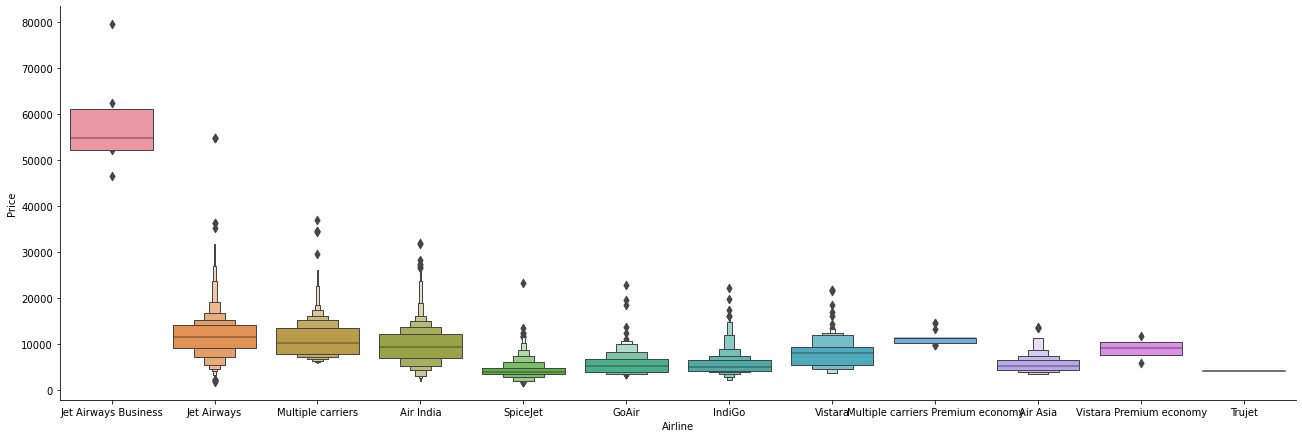

In [11]:
# we can observe that jet airways bussiness is he costliest airways
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

### Step 10 – Creating dummy columns out of the Airline column.

In [12]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

### Step 11 – Plotting Source vs Price.

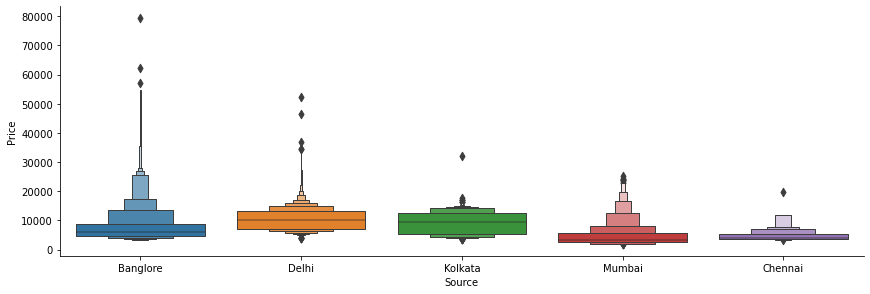

In [13]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

### Step 12 – Creating dummy columns out of the Source column.

In [14]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


### Step 13 – Plotting Destination vs Price.

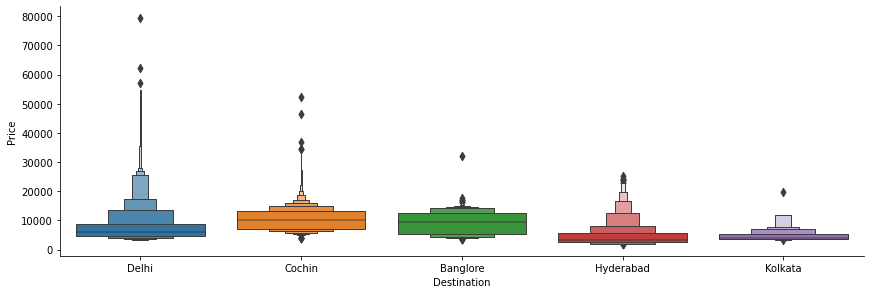

In [15]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

### Step 14 – Creating dummy columns out of the Destination column.

In [16]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


### Step 15 – Dropping unwanted columns.

In [17]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

### Step 16 – Checking values in the Total stops column.

In [18]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

### Step 17 – Converting labels into numbers in the Total_stops column.

In [19]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


### Step 18 – Checking shapes of our 4 data frames.

In [20]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10682, 11)
(10682, 4)
(10682, 4)
(10682, 13)


### Step 19 – Combine all 4 data frames.

In [21]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


# Feature Selection

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1. **heatmap** 
2. **feature_importance_** 
3. **SelectKBest**

In [22]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

### Step 20 – Taking out train data.

In [23]:
X = data_train.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0


### Step 21 – Taking out train data labels.

In [24]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

### Step 22 – Checking correlations between columns.

We can see that Total_stops is highly correlated with Duration_hours which is very obvious. If the no. of stops would increase, the duration hours of the flight will also increase.
Also, price is highly correlated with total stops because if stops would increase that would also require a high quantity of fuel, and that would increase the price.

<AxesSubplot:>

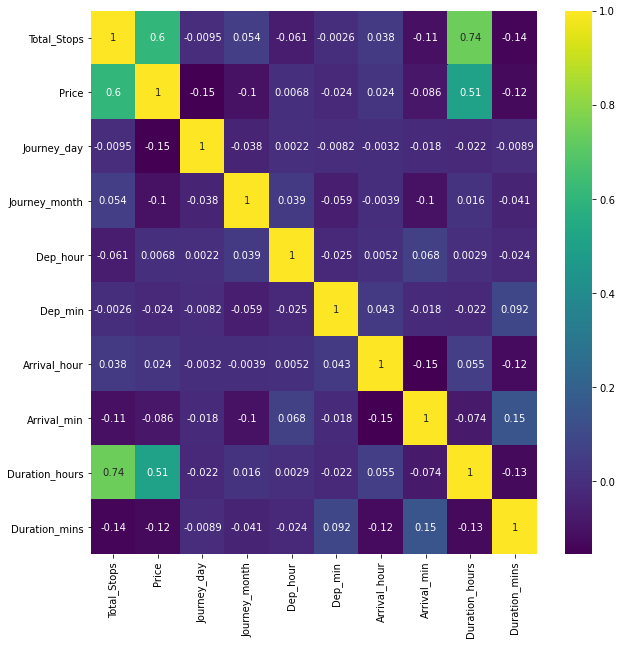

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

### Step 23 – First trying out ExtraTreesRegressor model for Flight Price Prediction.

In [26]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.42118549e-01 1.41448912e-01 5.91303034e-02 2.38993618e-02
 2.16033668e-02 2.81299743e-02 1.83018621e-02 1.24815117e-01
 1.82403069e-02 8.69868077e-03 1.89338947e-03 1.99078184e-02
 1.32982055e-01 6.74053654e-02 1.76079703e-02 8.63883802e-04
 6.06173113e-03 1.20024938e-04 4.38399754e-03 6.22695264e-05
 6.62675624e-04 9.30672332e-03 4.64336318e-03 9.23038823e-03
 1.11063376e-02 1.82274100e-02 8.31110590e-03 8.37056307e-04]


### Step 24 – Checking feature importance given by ExtraTreeRegressor.

Total_stops is the feature with the highest feature importance in deciding Price as we have also seen above.
After that Journey Day also plays a big role in deciding the Price. Prices are generally higher on weekends.

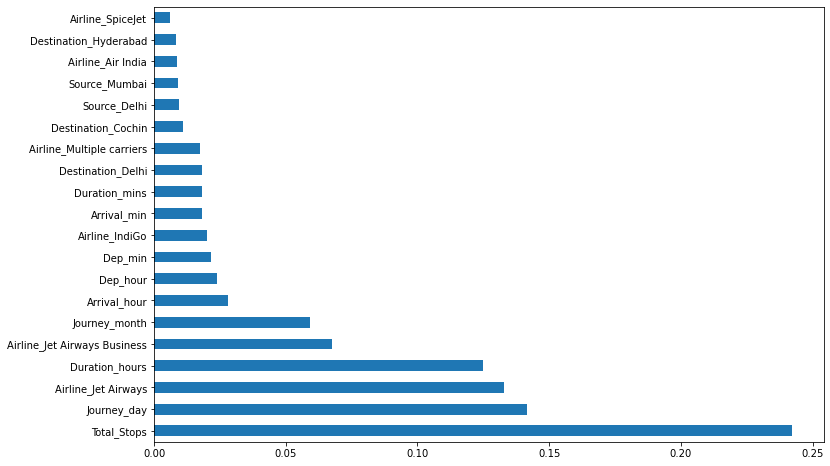

In [27]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Fitting model using Random Forest
1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data(Scaling is not done in Random forest)
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check RSME Score
7. Plot graph

### Step 25 – Splitting our data into Training and Testing data.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Step 26 – Training Random Forest Regressor model for Flight Price Prediction.

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

### Step 27 – Checking best parameters we got using Randomized Search CV.

In [30]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

### Step 28 – Taking Predictions

In [31]:
prediction = rf_random.predict(X_test)

### Step 29 – Plotting the residuals.

As we can see that most of the residuals are 0, which means our model is generalizing well.

C:\Users\NAYNI\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


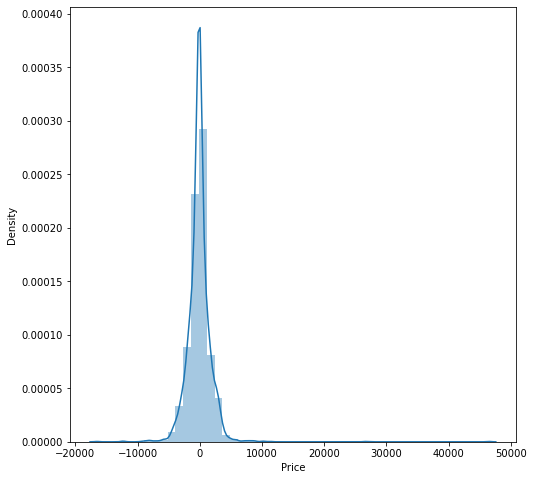

In [32]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

### Step 30 – Plotting y_test vs predictions.

Simply plotting our predictions vs the true values.
Ideally, it should be a straight line.

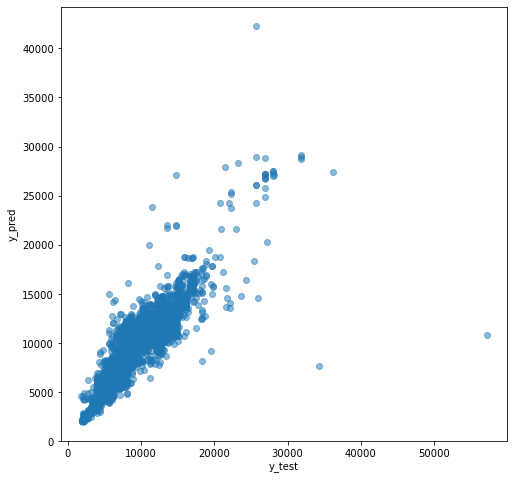

In [33]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### Step 31 – Printing metrics.

In [34]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.8128627974773135


### Save the model to reuse it again

In [35]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)